In [1]:
from typing import Literal
import numpy as np
from pogema import GridConfig
from pogema_toolbox.algorithm_config import AlgoBase
from pypibt.pibt import PIBT

class PIBTInferenceConfig(AlgoBase):
    name: Literal['PIBT'] = 'PIBT'


class PIBTInference:
    def __init__(self, cfg: PIBTInferenceConfig):
        self.cfg = cfg
        self.actions = {tuple(coord): i for i, coord in enumerate(GridConfig().MOVES)}
        self.agent = None
        self.configs = []
        self.timestep = 0

    def act(self, observations, rewards=None, dones=None, info=None, skip_agents=None):
        num_agents = len(observations)
        if self.timestep == 0:
            global_xy = [obs['global_xy'] for obs in observations]
            global_target_xy = [obs['global_target_xy'] for obs in observations]
            grid = np.array(observations[0]['global_obstacles']).astype(np.bool_)
            grid = np.logical_not(grid)
            self.agent = PIBT(grid, global_xy, global_target_xy)
            self.configs = self.agent.run()

        if self.timestep + 1 >= len(self.configs):
            return [0 for _ in range(num_agents)]
        cur_config = self.configs[self.timestep]
        next_config = self.configs[self.timestep + 1]
        self.timestep += 1
        actions = [self.actions[(next_config[i][0] - cur_config[i][0],
                                 next_config[i][1] - cur_config[i][1])]
                   for i in range(num_agents)]
        return actions

    def reset_states(self):
        self.agent = None
        self.configs = 0
        self.timestep = 0

In [24]:
from pogema_toolbox.registry import ToolboxRegistry

custom_map = """
.#...
.....
.#...
.....
"""

# Creating custom_map
custom_map = """
  ##!!##
  !!!!!!
  !!!!!!
  ##!!##
"""

grid_config=GridConfig(num_agents=5, size=8, obs_radius=2,
                                       observation_type='MAPF', on_target='nothing',
                                       collision_system='soft', seed=0, map=custom_map,
                        agents_xy=[(1, 3), (2, 2)]
                
                      )

# Registring custom_map
# ToolboxRegistry.register_maps({"warehouse": custom_map})

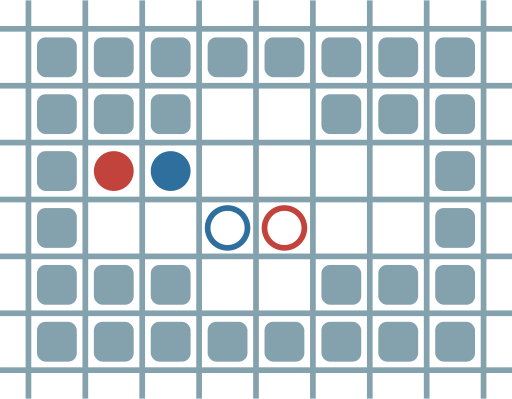

In [25]:
from pogema import pogema_v0, GridConfig, AnimationMonitor, AnimationConfig
from pogema_toolbox.run_episode import run_episode
from IPython.display import SVG, display
env = pogema_v0(grid_config)
env = AnimationMonitor(env)
agent = PIBTInference(PIBTInferenceConfig())

run_episode(env, agent)

env.save_animation("render.svg")
display(SVG('render.svg'))